# INTEGRATE Case Study example

This notebook contains an examples of the simplest use of INTEGRATE, on which tTEM data from various caswe study areas, will be be inverted using simple generic, resistivity only, prior models.


In [1]:
try:
    # Check if the code is running in an IPython kernel (which includes Jupyter notebooks)
    get_ipython()
    # If the above line doesn't raise an error, it means we are in a Jupyter environment
    # Execute the magic commands using IPython's run_line_magic function
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')
except:
    # If get_ipython() raises an error, we are not in a Jupyter environment
    # # #%load_ext autoreload
    # # #%autoreload 2
    pass

import integrate as ig
import numpy as np
import os
import matplotlib.pyplot as plt
hardcopy=True

## Download the data for a specific case study

The following case study areas are available: 

DAUGAARD
FANGEL
HALD


In [2]:
case = 'DAUGAARD'
#case = 'FANGEL'
#case = 'HALD'

files = ig.get_case_data(case=case)
f_data_h5 = files[0]
file_gex= ig.get_gex_file_from_data(f_data_h5)
# check that file_gex exists
if not os.path.isfile(file_gex):
    print("file_gex=%s does not exist in the current folder." % file_gex)

print('CASE: %s' % case)
print('Using hdf5 data file %s with gex file %s' % (f_data_h5,file_gex))

Getting data for case: HALD
File HALD_AVG.h5 already exists and is identical. Skipping download.
File TX07_20230731_2x4_RC20-33.gex already exists and is identical. Skipping download.
File README_HALD already exists and is identical. Skipping download.
CASE: HALD
Using hdf5 data file HALD_AVG.h5 with gex file TX07_20230731_2x4_RC20-33.gex


### Plot the geometry of the observed data

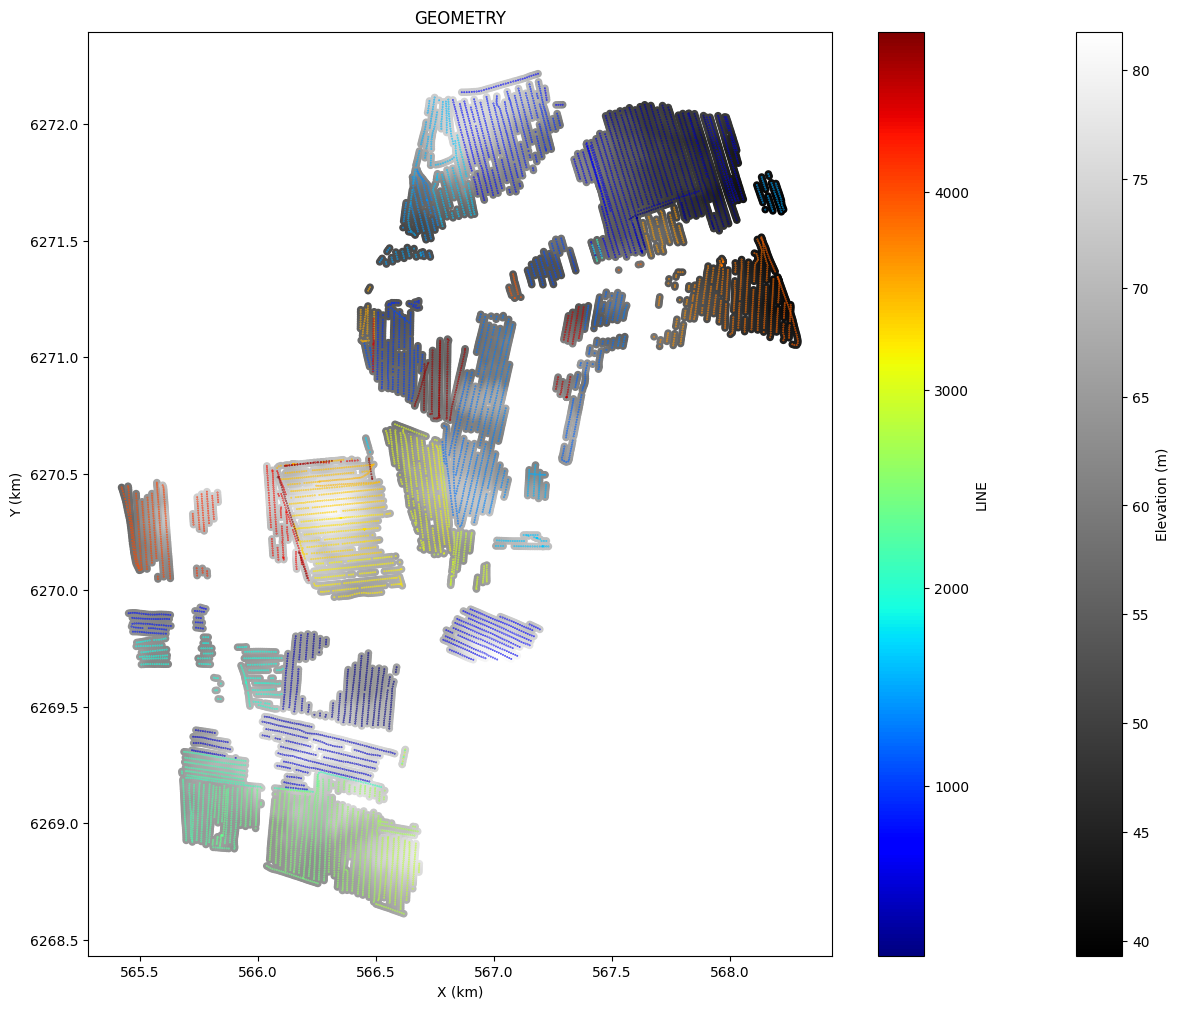

In [3]:
fig = ig.plot_data_xy(f_data_h5)

### Plot the observed data

plot_data: Found data set D1
plot_data: Using data set D1


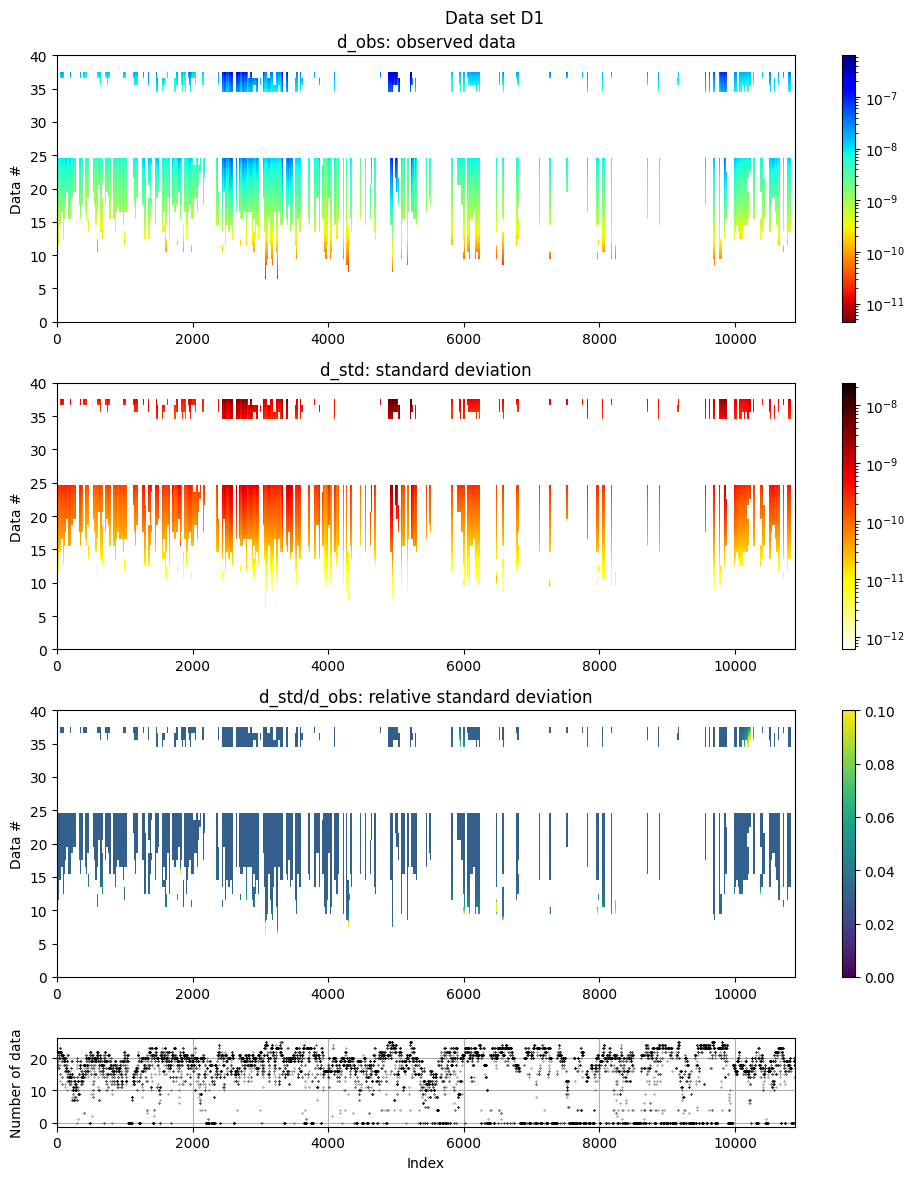

In [4]:
ig.plot_data(f_data_h5)

## Setup up the prior , $\rho(m,d)$
A lookup table of prior model parameters and corresponding prior data needs to be defined



### Prior model paramegters, $\rho(m)$: Setup the prior for the model parameters
In principle and arbitrarily complex prior can be used with INTEGRATE, quantifying information about both discrete and continuous model parameters, and modle parameters describing physical parameters, and geo related parameters.
Here, we consider using a simple generic resistivity only prior.



In [5]:
# A1. CONSTRUCT PRIOR MODEL OR USE EXISTING
N=100000
RHO_min = 10
RHO_max = 2500
RHO_max = 500
RHO_dist='log-uniform'
NLAY_min=4 
NLAY_max=4 
z_max = 90

useP=1
if useP==1:
    ## Layered model
    #f_prior_h5 = ig.prior_model_layered(N=N,lay_dist='chi2', NLAY_deg=5, z_max = z_max, RHO_dist='log-uniform', RHO_min=RHO_min, RHO_max=RHO_max)
    #f_prior_h5 = ig.prior_model_layered(N=N,lay_dist='uniform', z_max = z_max, NLAY_min=1, NLAY_max=3, RHO_dist='log-uniform', RHO_min=RHO_min, RHO_max=RHO_max)
    f_prior_h5 = ig.prior_model_layered(N=N,lay_dist='uniform', 
                                        z_max = z_max, 
                                        NLAY_min=NLAY_min, 
                                        NLAY_max=NLAY_max, 
                                        RHO_dist=RHO_dist, 
                                        RHO_min=RHO_min, 
                                        RHO_max=RHO_max)
elif useP==2:
    ## N layer model with increasing thickness
    f_prior_h5 = ig.prior_model_workbench(N=N, 
                                          RHO_mean=45, 
                                          RHO_std=45, 
                                          RHO_dist='log-normal', 
                                          z_max = z_max, 
                                          nlayers=1, 
                                          RHO_min = RHO_min, 
                                          RHO_max = RHO_max)
    #f_prior_h5 = ig.prior_model_workbench(N=N, z_max= 30, nlayers=20, RHO_min = RHO_min, RHO_max = RHO_max)
    f_prior_h5 = ig.prior_model_workbench(N=N, z_max = z_max, nlayers=NLAY_max, RHO_dist=RHO_dist, RHO_min = RHO_min, RHO_max = RHO_max)
    
else:
    f_prior_h5 = 'existing_prior.h5'

Saving prior model to PRIOR_WB1_N10000_log-normal_R45_45.h5
Saving prior model to PRIOR_WB4_N10000_log-uniform_R10_2500.h5


/mnt/d/PROGRAMMING/integrate_module/integrate/integrate_plot.py:873: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0,1].set_xticklabels(['$10^{%3.1f}$'%i for i in ax[0,1].get_xticks()])


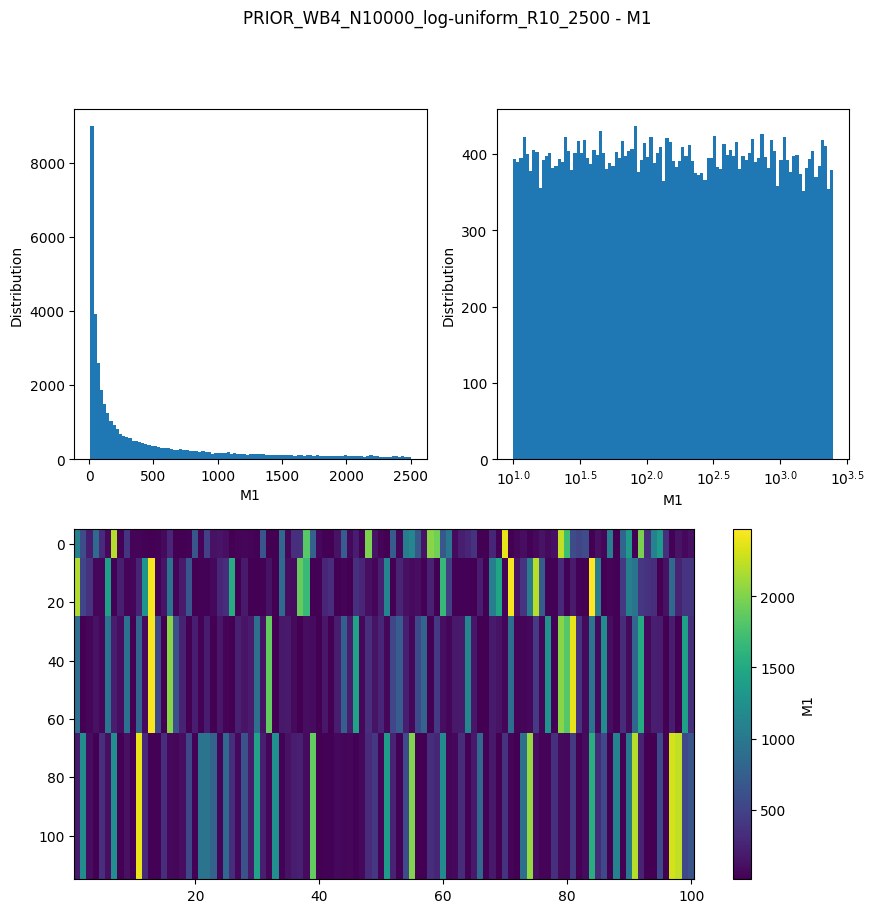

In [6]:
ig.plot_prior_stats(f_prior_h5)

### Prior data, $\rho(d)$
The prior data, i.e. the forwward response of of the realizations of the prior needs to be computed. Here we use only tTEM data, so onæy on type (tTEM) of data is computed.

In [7]:
f_prior_data_h5 = ig.prior_data_gaaem(f_prior_h5, file_gex)

N=10000, N_in=10000
Creating a copy of PRIOR_WB4_N10000_log-uniform_R10_2500.h5 as PRIOR_WB4_N10000_log-uniform_R10_2500_TX07_20230731_2x4_RC20-33_Nh280_Nf12.h5


 91%|█████████████████████████████████████████████████████████████████████████▋       | 142/156 [00:23<00:01,  7.73it/s]

 81%|█████████████████████████████████████████████████████████████████▉               | 127/156 [00:24<00:04,  6.23it/s]

 76%|█████████████████████████████████████████████████████████████▊                   | 119/156 [00:25<00:07,  4.88it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.95it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.83it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [00:27<00:00,  5.66it/s]


Concatenating D_chunks
D.shape (10000, 40)
Time elapsed:  29.5 s, for 10000 soundings. 2.952 ms/sounding. 338.8it/s


## Sample the posterior $\sigma(\mathbf{m})$

The posterior distribution is sampling using the extended rejection sampler.

In [8]:

N_use = 10000000
#f_prior_data_h5 = 'gotaelv2_N1000000_fraastad_ttem_Nh280_Nf12.h5'
updatePostStat =True
f_post_h5 = ig.integrate_rejection(f_prior_data_h5, f_data_h5, N_use = N_use, parallel=1, updatePostStat=updatePostStat, showInfo=1)




Running: integrate_rejection.py PRIOR_WB4_N10000_log-uniform_R10_2500_TX07_20230731_2x4_RC20-33_Nh280_Nf12.h5 HALD_AVG.h5 --autoT 1 --N_use 10000000 --ns 400 -parallel 1 --updatePostStat 1
psm_ef04f3e6
File POST_HALD_AVG_PRIOR_WB4_N10000_log-uniform_R10_2500_TX07_20230731_2x4_RC20-33_Nh280_Nf12_Nu10000_aT1.h5 allready exists
Overwriting...
nsoundings:10891, N_use:10000, nd:40
Writing results to  POST_HALD_AVG_PRIOR_WB4_N10000_log-uniform_R10_2500_TX07_20230731_2x4_RC20-33_Nh280_Nf12_Nu10000_aT1.h5
Using 32 parallel threads.


100%|████████████████████████████████████████████████████████████████████████████| 10891/10891 [00:27<00:00, 390.55it/s]


T_av=27.4, Time= 28.2s/10891 soundings ,2.593ms/sounding
Writing to file:  POST_HALD_AVG_PRIOR_WB4_N10000_log-uniform_R10_2500_TX07_20230731_2x4_RC20-33_Nh280_Nf12_Nu10000_aT1.h5
PRIOR_WB4_N10000_log-uniform_R10_2500_TX07_20230731_2x4_RC20-33_Nh280_Nf12.h5: M1.is_discrete=0
D1: NOT RECOGNIZED
M1: CONTINUOUS
Creating /M1/Mean
Creating /M1/Median
Creating /M1/Std


100%|███████████████████████████████████████████████████████████████████████████| 10891/10891 [00:02<00:00, 4942.96it/s]


## Plot some statistics from $\sigma(\mathbf{m})$

### The temperature refer to the annealing temperature used by the extended rejection sampler, in order to get 'enough' realizations.
T=1, implies no anealing has occurred. Higher values of T implies increasingly difficulty of fitting the data within the noise, suggesting either that the lookup table size is too small and/or that the prior is not consistent with the data.

(1, 100)
EV_min=-100.000000, EV_max=0.000000
[18 20 20 ... 14 14 14]


1

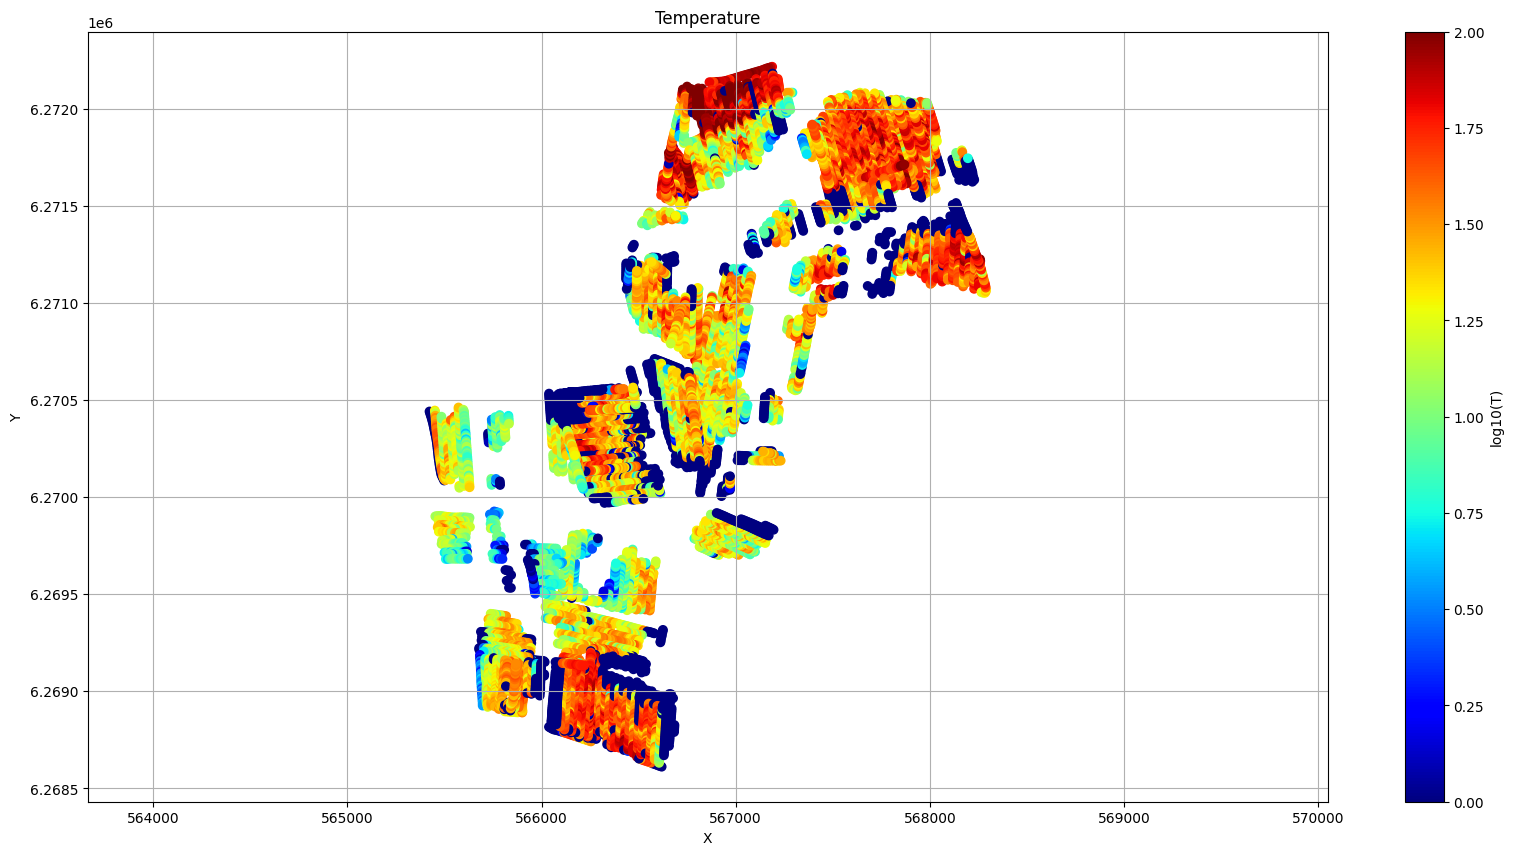

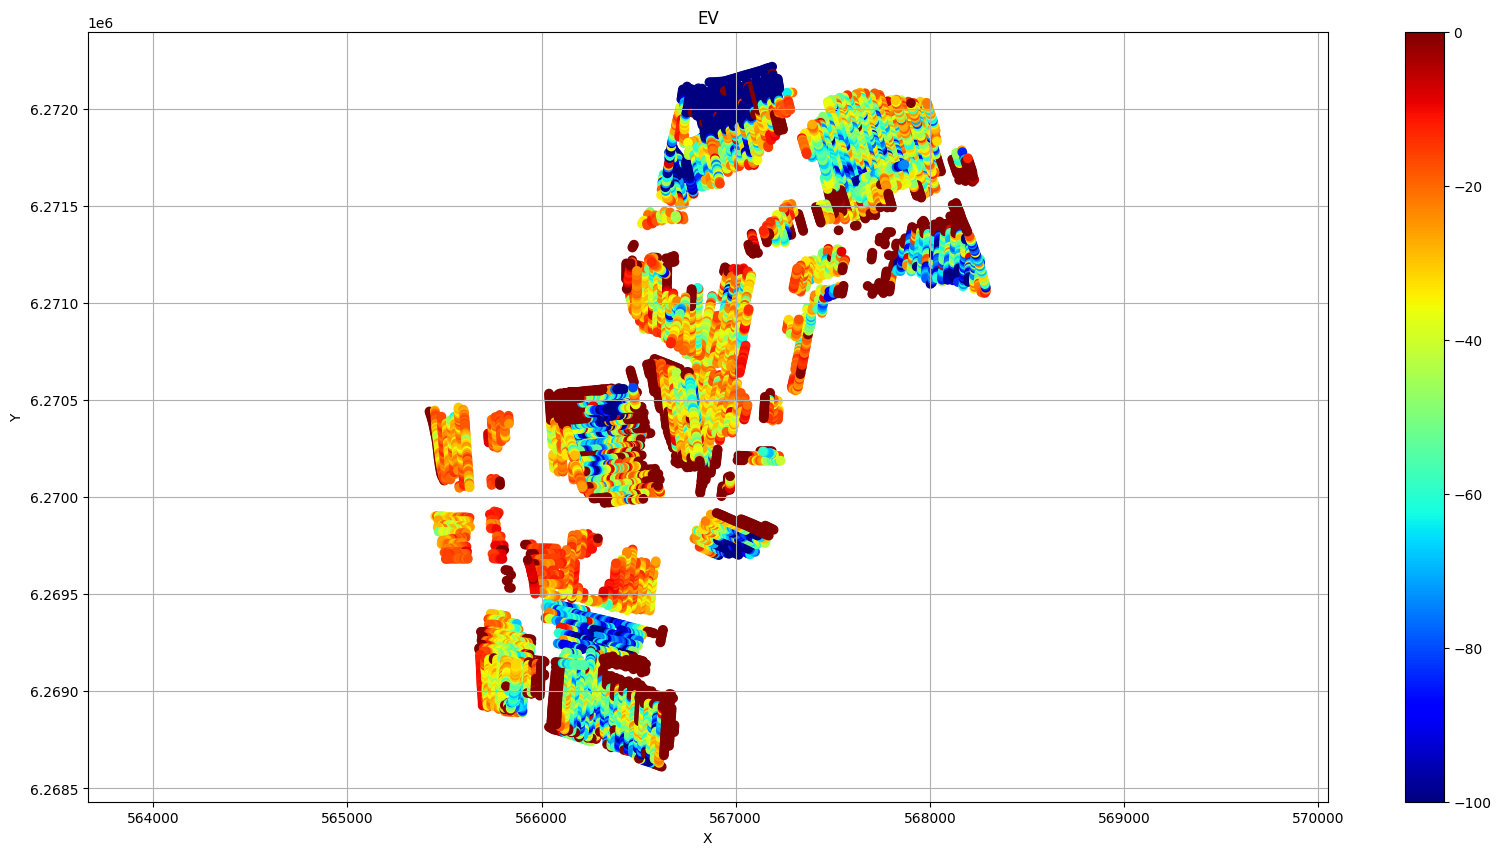

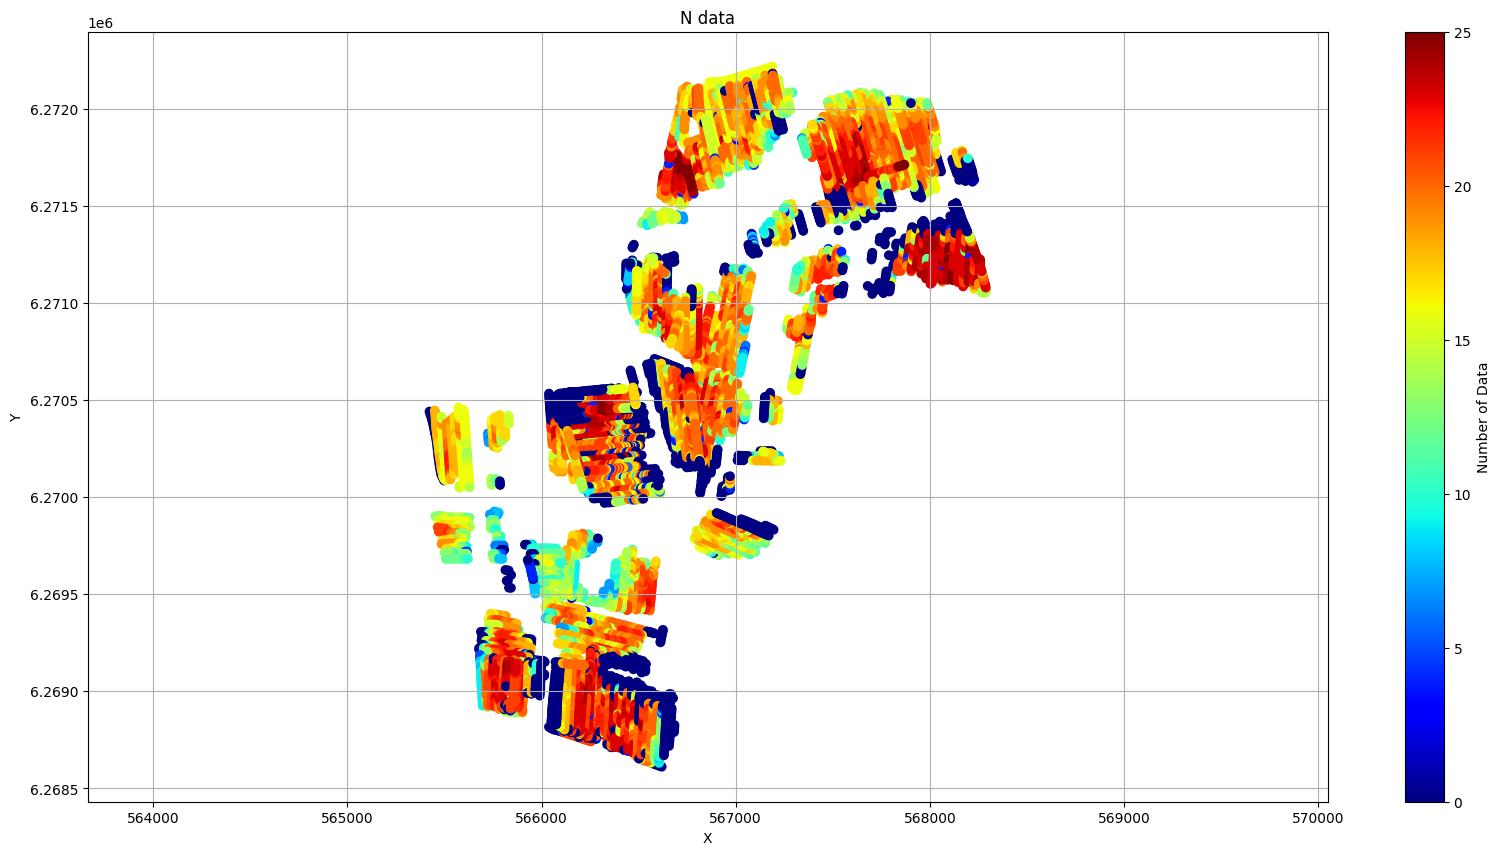

In [9]:
# Plot the Temperature used for inversion
ig.plot_T_EV(f_post_h5, pl='T')
ig.plot_T_EV(f_post_h5, pl='EV')
ig.plot_T_EV(f_post_h5, pl='ND')
#

20.86428040172214
42.380830760173524
37.07539694990765
6.6025901037751344


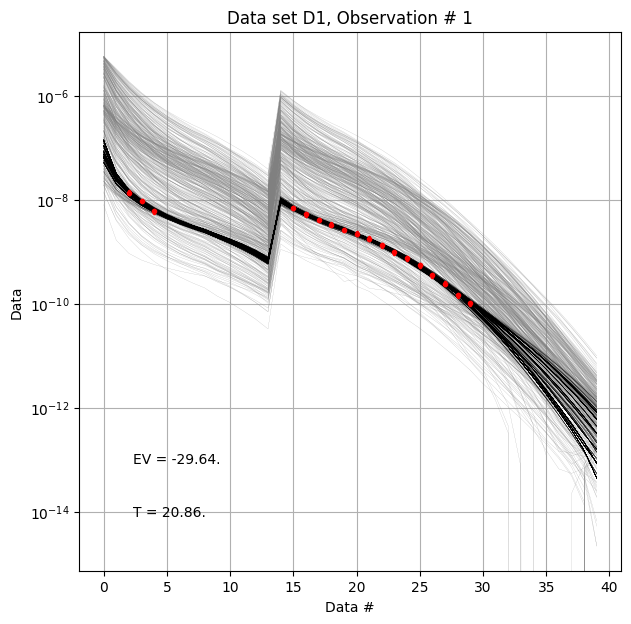

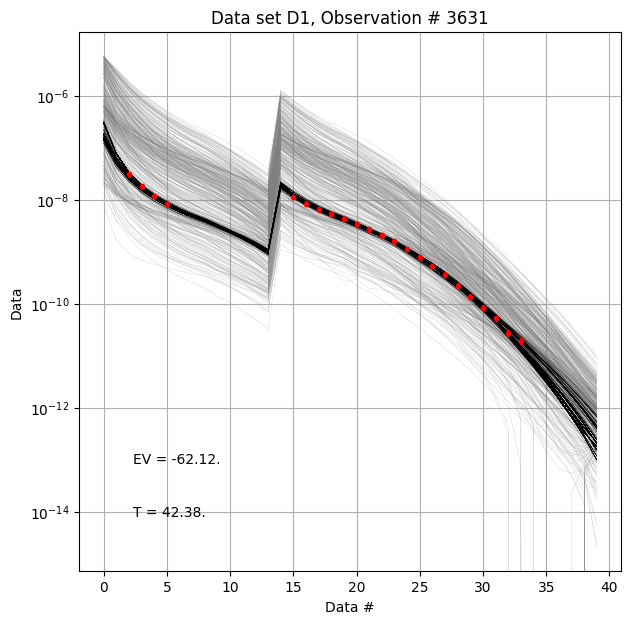

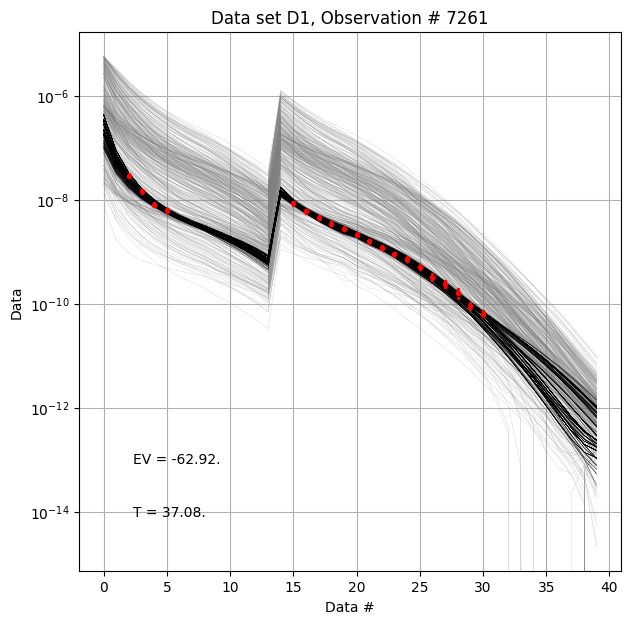

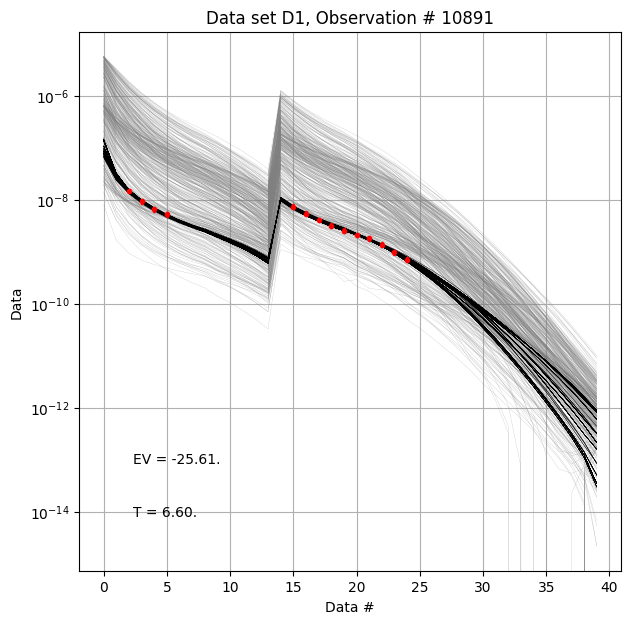

In [10]:
import h5py
with h5py.File(f_data_h5,'r') as f_prior:
    nd=f_prior['UTMX'].shape[0]


i1 = np.linspace(0,nd-1,4).astype(int)
for i in i1:
    ig.plot_data_prior_post(f_post_h5, i_plot = i)
    #ig.plot_data_prior_post(f_post_h5, i_plot = 1199)

0
Plot profile for all model parameters
1
Plotting profile /M1 from POST_HALD_AVG_PRIOR_WB4_N10000_log-uniform_R10_2500_TX07_20230731_2x4_RC20-33_Nh280_Nf12_Nu10000_aT1.h5
[10, 500]
jet
[10, 500]


/mnt/d/PROGRAMMING/integrate_module/integrate/integrate_plot.py:564: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im1 = ax[0].pcolormesh(ID[:,i1:i2], ZZ[:,i1:i2], Mean[:,i1:i2],
/mnt/d/PROGRAMMING/integrate_module/integrate/integrate_plot.py:573: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im2 = ax[1].pcolormesh(ID[:,i1:i2], ZZ[:,i1:i2], Median[:,i1:i2],
/mnt/d/PROGRAMMING/integrate_module/integrate/integrate_plot.py:583: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrec

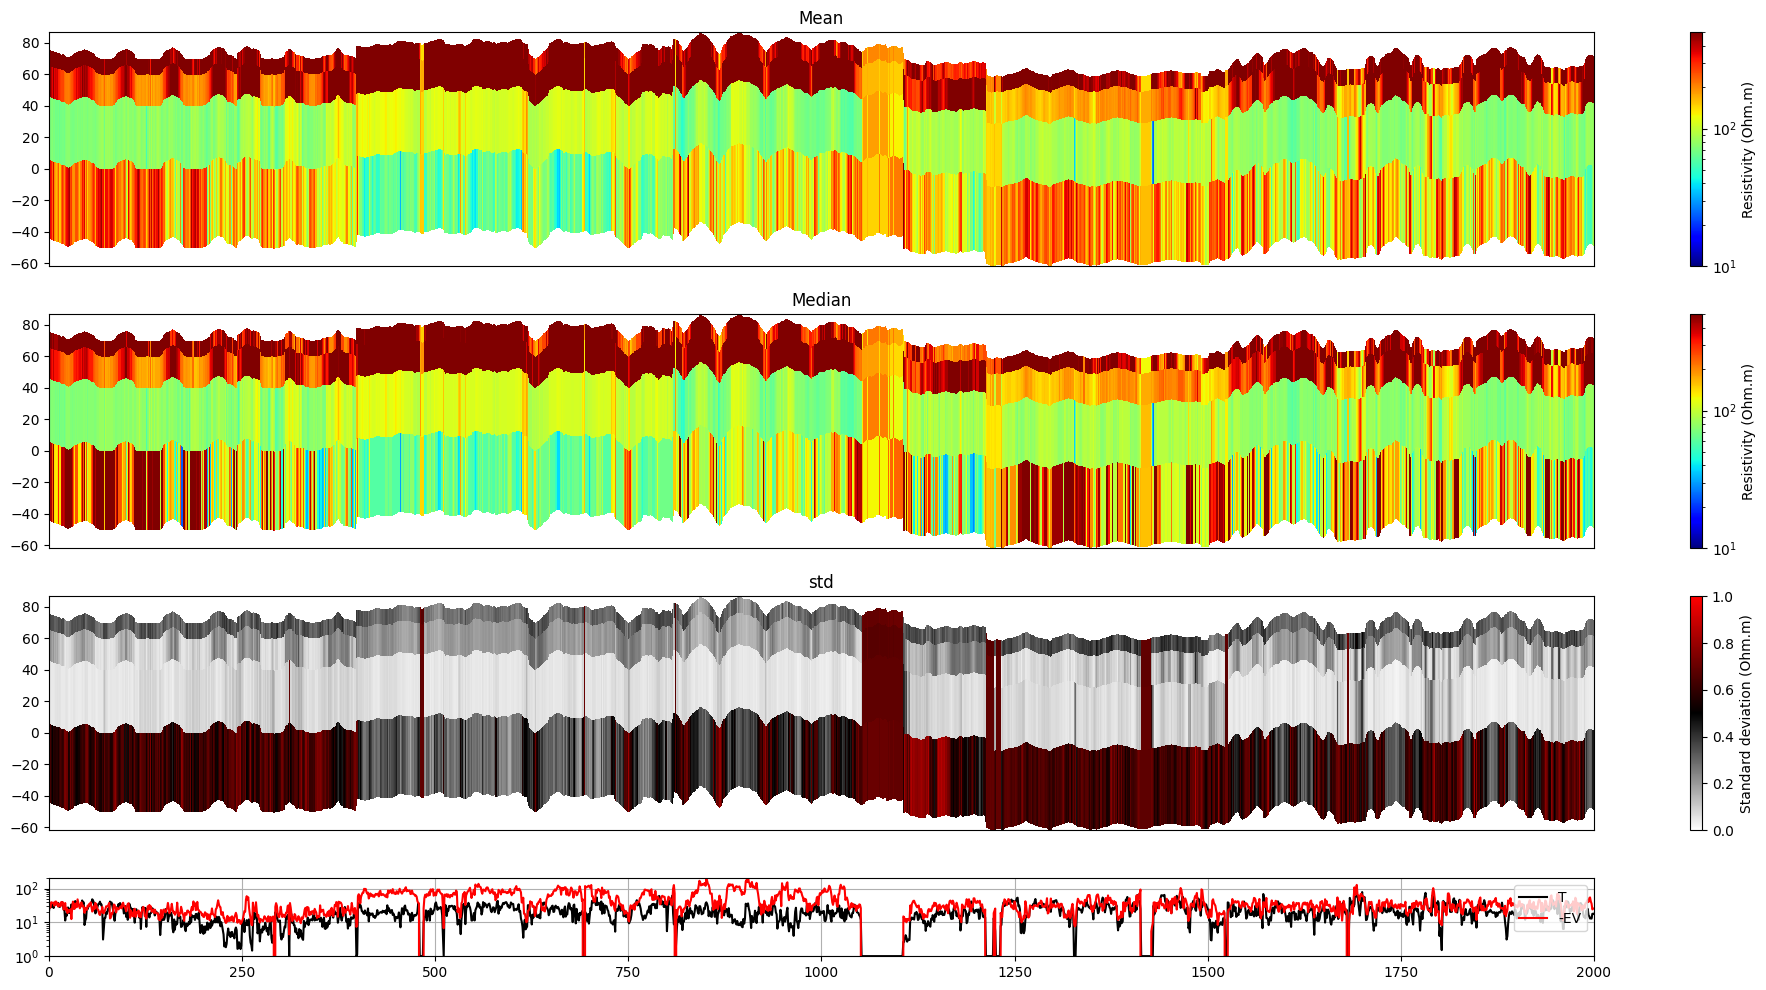

1

In [11]:
ig.plot_profile(f_post_h5, i1=0, i2=np.min([2000,nd]), cmap='jet', hardcopy=hardcopy)

Plotting Feature 0 from /M1/Mean
(10891,)


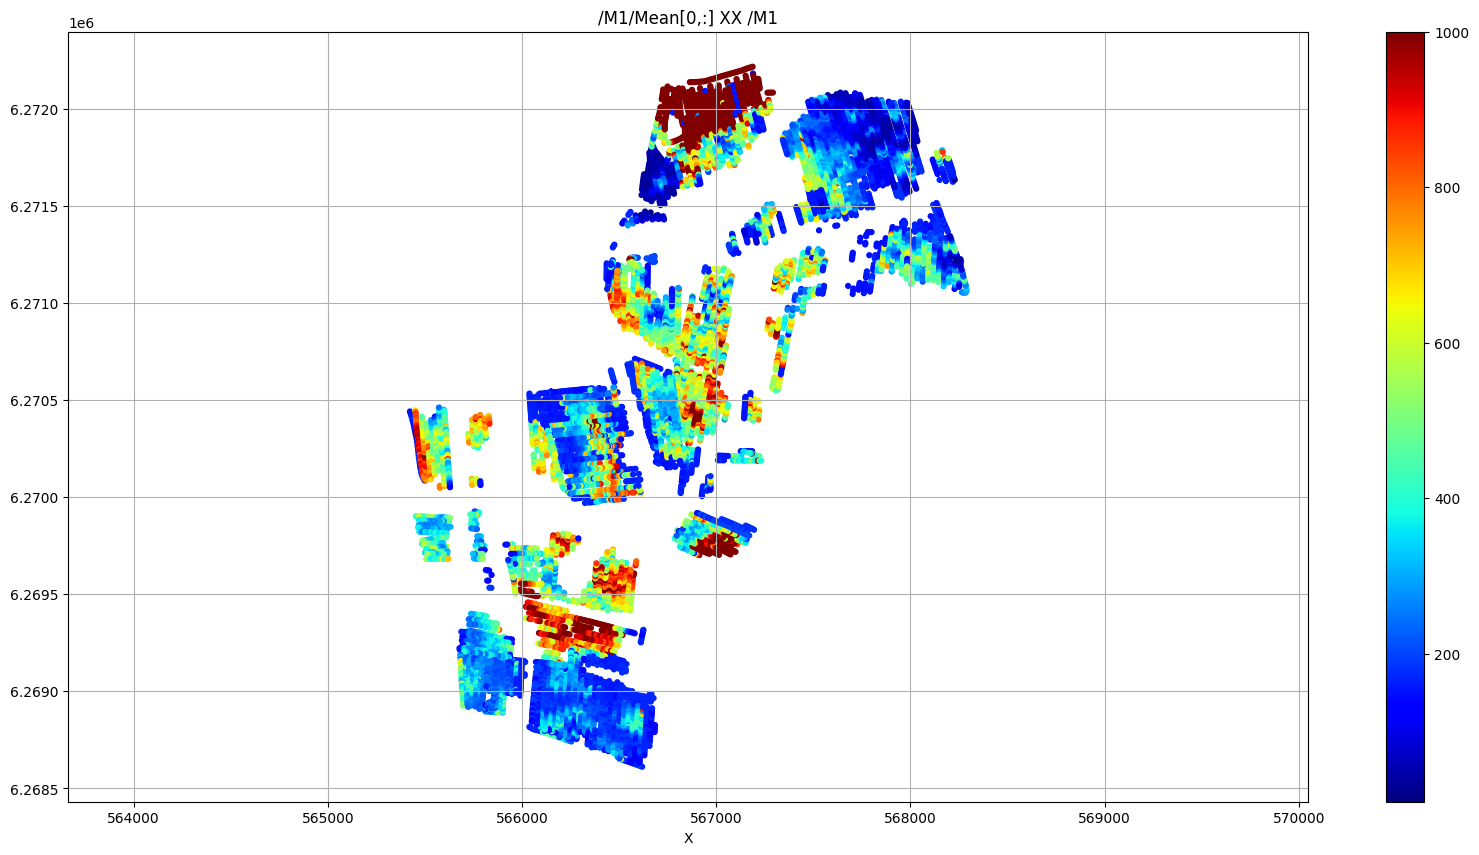

Plotting Feature 5 from /M1/Mean


IndexError: Index (5) out of range for (0-3)

In [12]:
for iz in range(0,z_max,5):
    ig.plot_feature_2d(f_post_h5,im=1,iz=iz,key='Mean', title_text = 'XX', cmap='jet', s=12, vmin=10, vmax=100, hardcopy=hardcopy)

In [13]:
ig.post_to_csv(f_post_h5)

Writing to POST_HALD_AVG_PRIOR_WB4_N10000_log-uniform_R10_2500_TX07_20230731_2x4_RC20-33_Nh280_Nf12_Nu10000_aT1_M1.csv


'POST_HALD_AVG_PRIOR_WB4_N10000_log-uniform_R10_2500_TX07_20230731_2x4_RC20-33_Nh280_Nf12_Nu10000_aT1_M1.csv'